------------
__Ojective__ <br>

Develop image-classification for festival recognition. 

------------
__Resources__ <br>

---------------
__Data Source__  : [Kaggle Project](https://www.kaggle.com/singh10tejas/Festivals?select=Holi) <br>

__Learning Resource__  : [Tensor flow](https://www.tensorflow.org/tutorials/images/classification) <br>

------------

### Loading Libraries

In [1]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

#---------------------------------------------
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks

In [2]:
# Multiple print statments in a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Adjust the Display options for number of rows and columns 
pd.set_option("display.max_columns", 500)
pd.set_option("display.min_rows", 500)

**Set-up the Folder Structure**

In [3]:
# Set the current folder location as where the data resides

Data_Folder_Path = os.getcwd() + '/InputDF/'

print("Current Folder path is : ",Data_Folder_Path)
print('\n')
print("Please change this path accordingly!")



Current Folder path is :  /Users/g0p00cc/Desktop/Superprof/Rishabh/Computer Vision/Festival_Classification/InputDF/


Please change this path accordingly!


In [4]:
print(f'Please do not change the random-state-seed for reproducing the exact same results')
sel_random_state = 123

Please do not change the random-state-seed for reproducing the exact same results


We have the data saved in the local system. Let's load this data first.

In [5]:
All_Festivals = os.listdir(Data_Folder_Path)
All_Festivals

['Lohri', 'Ganesh Chaturthi', 'Christmas', 'Diwali', 'EID', 'Independence Day']

In [8]:
# Notice that the hidden file '.DS_Store' is also listed. We will remove this

if '.DS_Store' in All_Festivals :
    All_Festivals.remove('.DS_Store')
    
print(All_Festivals)

['Lohri', 'Ganesh Chaturthi', 'Christmas', 'Diwali', 'EID', 'Independence Day']


### How many images are there for each category?

In [9]:
DF_Image_Count = pd.DataFrame()


for i in All_Festivals:
    
    # Number of image files in this feastival-folder
    N_File = len(os.listdir(Data_Folder_Path + i))

    DF_Image_Count = DF_Image_Count.append({'Festival_Name' : i,'N_File' : N_File},ignore_index = True)
    

In [10]:
DF_Image_Count

,Festival_Name,N_File
0,Lohri,537.0
1,Ganesh Chaturthi,626.0
2,Christmas,645.0
3,Diwali,544.0
4,EID,649.0
5,Independence Day,669.0


In [11]:
print(f'Total number of images are : {DF_Image_Count.N_File.sum()}')

Total number of images are : 3670.0


In [12]:
DF_Image_Count.N_File/DF_Image_Count.N_File.sum()

0    0.146322
1    0.170572
2    0.175749
3    0.148229
4    0.176839
5    0.182289
Name: N_File, dtype: float64

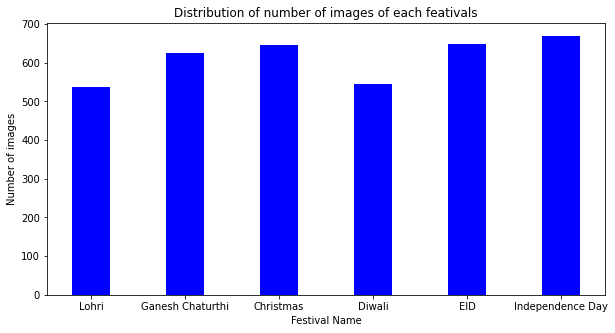

In [13]:
# Bar plot : How many images for each featival we have?


fig = plt.figure(figsize = (10, 5))
plt.bar(DF_Image_Count['Festival_Name'], DF_Image_Count['N_File'], color ='blue',width = 0.4)
#plt.xticks(rotation=-5)
plt.xlabel("Festival Name")
plt.ylabel("Number of images")
plt.title("Distribution of number of images of each feativals")
plt.show();

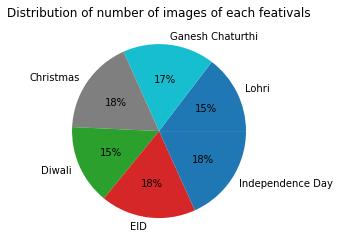

In [14]:
fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:green', 'tab:red']
ax.pie(DF_Image_Count.N_File, labels = DF_Image_Count.Festival_Name,colors = colors,autopct='%.0f%%')
ax.set_title('Distribution of number of images of each feativals')
plt.show();

### NOTE - There is not evident class-imbalance in the data

### Let's see an sample image at random

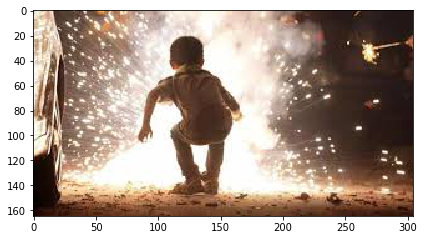

In [16]:
from skimage.io import imread, imshow

import random

folder_num = random.randint(0,len(All_Festivals))
im_num = random.randint(0,50)

folder_path = Data_Folder_Path + All_Festivals[folder_num]
image = imread(os.path.join(folder_path,os.listdir(folder_path)[im_num]))
imshow(image);

In [17]:
image.shape

(165, 305, 3)

### NOTE : Images are of different height and widths

In [18]:
df_image_dim = pd.DataFrame()


for i in tqdm(range(len(All_Festivals))):
    
    folder_path = Data_Folder_Path + All_Festivals[i]
    
    folder_name = All_Festivals[i]
    
    for j in range(len(os.listdir(folder_path))):
        
        image = imread(os.path.join(folder_path,os.listdir(folder_path)[im_num]))
        
        image_height = image.shape[0]
        image_width  = image.shape[1]
        image_rgb    = image.shape[2]
        
        df_image_dim = df_image_dim.append({'Festival_Name' : folder_name,
                                            'image_height' : image_height,
                                           'image_width' : image_width,
                                           'image_rgb' : image_rgb},ignore_index = True)

100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.24s/it]


In [19]:
df_image_dim.head()
df_image_dim.shape

,Festival_Name,image_height,image_width,image_rgb
0,Lohri,177.0,285.0,3.0
1,Lohri,177.0,285.0,3.0
2,Lohri,177.0,285.0,3.0
3,Lohri,177.0,285.0,3.0
4,Lohri,177.0,285.0,3.0


(3670, 4)

In [20]:
df_image_dim.image_rgb.unique()
# All images are of RGB format

array([3.])

In [21]:
df_image_dim.groupby(['Festival_Name']).agg({'image_height':'mean',
                                            'image_width':'mean'}).reset_index()

,Festival_Name,image_height,image_width
0,Christmas,194.0,259.0
1,Diwali,165.0,305.0
2,EID,168.0,299.0
3,Ganesh Chaturthi,195.0,259.0
4,Independence Day,183.0,275.0
5,Lohri,177.0,285.0


In [22]:
df_image_dim.image_height.mean()
df_image_dim.image_width.mean()

180.7814713896458

279.61307901907355

### Because the data is not already seperated into train and test, we need to do that.

In [23]:
batch_size = 32
img_height = int(df_image_dim.image_height.mean())
img_width = int(df_image_dim.image_width.mean())


print(f'Batch Size : {batch_size} || Image Height : {img_height} || Image Width : {img_width}')

Batch Size : 32 || Image Height : 180 || Image Width : 279


In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  Data_Folder_Path,
  validation_split=0.2,
  subset="training",
  seed=sel_random_state,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 6 classes.
Using 2936 files for training.


2022-06-06 21:26:19.773985: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  Data_Folder_Path,
  validation_split=0.2,
  subset="validation",
  seed=sel_random_state,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 6 classes.
Using 734 files for validation.


In [26]:
class_names = train_ds.class_names
print(class_names)

['Christmas', 'Diwali', 'EID', 'Ganesh Chaturthi', 'Independence Day', 'Lohri']


### Let's see some sample images from the Training Data

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Independence Day')

(-0.5, 278.5, 179.5, -0.5)

Text(0.5, 1.0, 'Independence Day')

(-0.5, 278.5, 179.5, -0.5)

Text(0.5, 1.0, 'Lohri')

(-0.5, 278.5, 179.5, -0.5)

Text(0.5, 1.0, 'Lohri')

(-0.5, 278.5, 179.5, -0.5)

Text(0.5, 1.0, 'Diwali')

(-0.5, 278.5, 179.5, -0.5)

Text(0.5, 1.0, 'Ganesh Chaturthi')

(-0.5, 278.5, 179.5, -0.5)

Text(0.5, 1.0, 'Independence Day')

(-0.5, 278.5, 179.5, -0.5)

Text(0.5, 1.0, 'Ganesh Chaturthi')

(-0.5, 278.5, 179.5, -0.5)

Text(0.5, 1.0, 'Lohri')

(-0.5, 278.5, 179.5, -0.5)

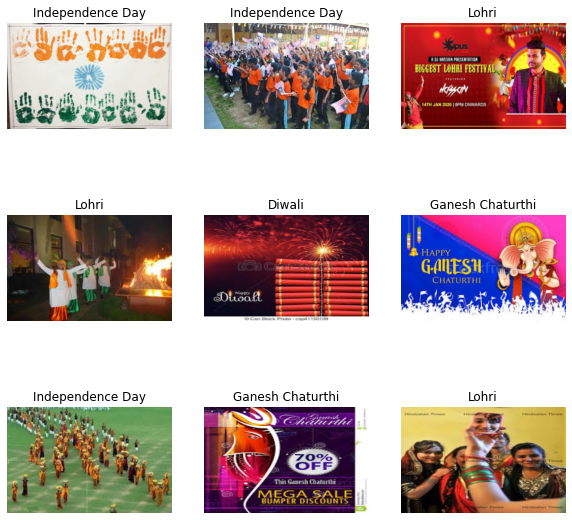

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off");

### We will normalize the values and bring them to a 0-1 scale

In [29]:
normalization_layer = layers.Rescaling(1./255)

In [30]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))


In [31]:
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [32]:
num_classes = len(All_Festivals)
print(f'Number of classes: {num_classes}')

Number of classes: 6


In [33]:
data_augmentation = keras.Sequential(
  [layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
   layers.RandomRotation(0.1),
   layers.RandomZoom(0.1),
  ]
)

<Figure size 720x720 with 0 Axes>

(-0.5, 278.5, 179.5, -0.5)

(-0.5, 278.5, 179.5, -0.5)

(-0.5, 278.5, 179.5, -0.5)

(-0.5, 278.5, 179.5, -0.5)

(-0.5, 278.5, 179.5, -0.5)

(-0.5, 278.5, 179.5, -0.5)

(-0.5, 278.5, 179.5, -0.5)

(-0.5, 278.5, 179.5, -0.5)

(-0.5, 278.5, 179.5, -0.5)

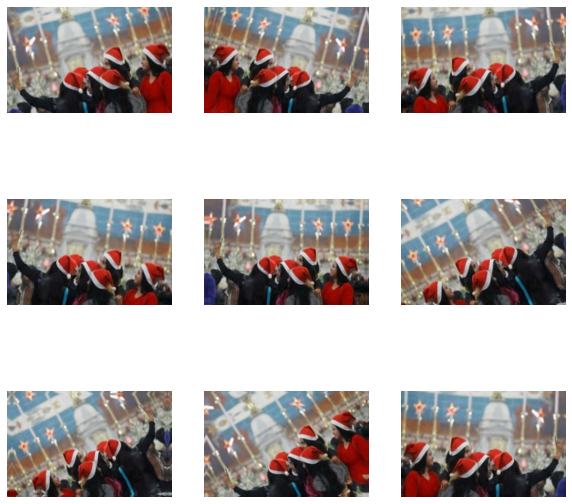

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### Neural Network

In [35]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 279, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 279, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 279, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 139, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 139, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 69, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 69, 64)       

In [38]:
epochs=25

In [39]:
%%time

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
92/92 [==============================] - 58s 621ms/step - loss: 1.7929 - accuracy: 0.2275 - val_loss: 1.6718 - val_accuracy: 0.2997
Epoch 2/25
92/92 [==============================] - 59s 642ms/step - loss: 1.6476 - accuracy: 0.3096 - val_loss: 1.5945 - val_accuracy: 0.3542
Epoch 3/25
92/92 [==============================] - 55s 598ms/step - loss: 1.5830 - accuracy: 0.3665 - val_loss: 1.6178 - val_accuracy: 0.3147
Epoch 4/25
92/92 [==============================] - 56s 613ms/step - loss: 1.5504 - accuracy: 0.3907 - val_loss: 1.5127 - val_accuracy: 0.3978
Epoch 5/25
92/92 [==============================] - 53s 572ms/step - loss: 1.5080 - accuracy: 0.4121 - val_loss: 1.4925 - val_accuracy: 0.4169
Epoch 6/25
92/92 [==============================] - 53s 575ms/step - loss: 1.4648 - accuracy: 0.4240 - val_loss: 1.5275 - val_accuracy: 0.4101
Epoch 7/25
92/92 [==============================] - 56s 606ms/step - loss: 1.4231 - accuracy: 0.4537 - val_loss: 1.5145 - val_accuracy: 0.4210

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [42]:
len(acc)
len(val_acc)
len(loss)
len(val_loss)

25

25

25

25

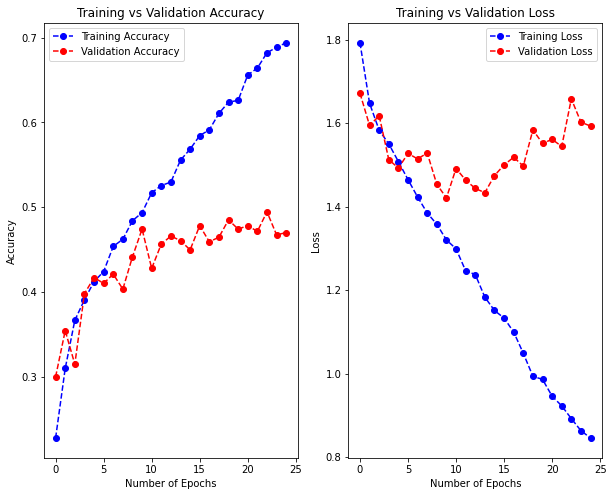

In [43]:
epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,'bo--', label='Training Accuracy')
plt.plot(epochs_range, val_acc,'ro--', label='Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend(loc='upper left')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,'bo--', label='Training Loss')
plt.plot(epochs_range, val_loss,'ro--', label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show();

In [44]:
train_actual_label = np.concatenate([y for x, y in train_ds], axis=0)
len(train_actual_label)

2936

In [45]:
train_actual_label

array([2, 3, 1, ..., 3, 5, 4], dtype=int32)

In [46]:
train_ds

<BatchDataset shapes: ((None, 180, 279, 3), (None,)), types: (tf.float32, tf.int32)>

In [47]:
valid_actual_label = np.concatenate([y for x, y in val_ds], axis=0)
len(valid_actual_label)

734

In [48]:
# Training predictions
train_pred_label = np.argmax(model.predict(train_ds), axis = 1)

valid_pred_label = np.argmax(model.predict(val_ds), axis = 1)

In [49]:
train_pred_label

array([1, 3, 2, ..., 4, 2, 5])

In [50]:
len(train_pred_label)
len(valid_pred_label)

2936

734

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [52]:
train_cm = confusion_matrix(train_actual_label, train_pred_label)
train_cm

array([[ 96,  57,  77, 105, 118,  60],
       [ 82,  61,  69,  85,  97,  49],
       [119,  62,  87,  95,  97,  60],
       [115,  64,  74,  80, 104,  75],
       [101,  56,  85,  94, 110,  68],
       [ 94,  60,  72,  73,  82,  53]])

In [53]:
print(classification_report(train_actual_label, train_pred_label))

              precision    recall  f1-score   support

           0       0.16      0.19      0.17       513
           1       0.17      0.14      0.15       443
           2       0.19      0.17      0.18       520
           3       0.15      0.16      0.15       512
           4       0.18      0.21      0.20       514
           5       0.15      0.12      0.13       434

    accuracy                           0.17      2936
   macro avg       0.17      0.16      0.16      2936
weighted avg       0.17      0.17      0.16      2936



In [54]:
def f_CM_HeatMap(ConfusionMatrix,Title_Text):
    
    '''Function for producing a Heatmap Representation of the Confusion Matrix'''
    
    df_cm = pd.DataFrame(ConfusionMatrix)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    plt.title(Title_Text)
    sns.set(font_scale=1.4)
     #sn.heatmap(df_cm, cmap="BuGn", annot=True,annot_kws={"size": 16})
    heat_map = sns.heatmap(df_cm, cmap="BuGn", annot=True,annot_kws={"size": 16}, fmt='.1f');
    
    return (heat_map)

<AxesSubplot:title={'center':'Confusion Matrix (Train)'}, xlabel='Predicted', ylabel='Actual'>

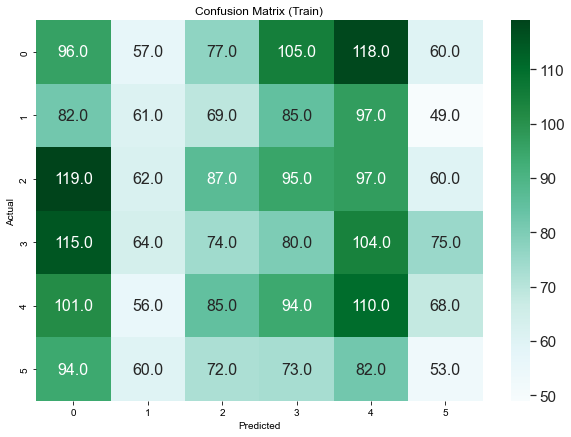

In [55]:
f_CM_HeatMap(ConfusionMatrix = train_cm, Title_Text = 'Confusion Matrix (Train)')

In [56]:
vaid_cm = confusion_matrix(valid_actual_label, valid_pred_label)
vaid_cm

array([[27, 15, 23, 19, 38, 10],
       [18, 10, 16, 17, 26, 14],
       [20, 19, 20, 23, 31, 16],
       [32,  8, 21, 17, 23, 13],
       [26, 18, 19, 31, 39, 22],
       [17, 10, 18, 20, 26, 12]])

In [57]:
print(classification_report(valid_actual_label, valid_pred_label))

              precision    recall  f1-score   support

           0       0.19      0.20      0.20       132
           1       0.12      0.10      0.11       101
           2       0.17      0.16      0.16       129
           3       0.13      0.15      0.14       114
           4       0.21      0.25      0.23       155
           5       0.14      0.12      0.13       103

    accuracy                           0.17       734
   macro avg       0.16      0.16      0.16       734
weighted avg       0.17      0.17      0.17       734



<AxesSubplot:title={'center':'Confusion Matrix (Valid)'}, xlabel='Predicted', ylabel='Actual'>

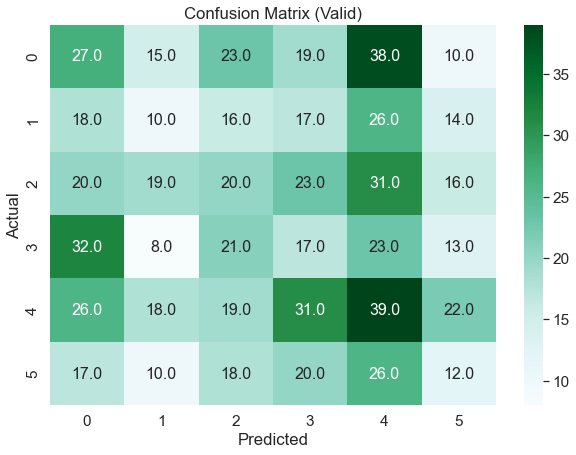

In [58]:
f_CM_HeatMap(ConfusionMatrix = vaid_cm, Title_Text = 'Confusion Matrix (Valid)')